In [596]:
#importing libraries and setting the graphics parameters 
import wrds
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

db = wrds.Connection(wrds_username="djolitto")


#setting graphics parameters
plt.rcParams['figure.figsize'] = [11.0, 5.0]
plt.rcParams['figure.dpi'] = 80


#downloading data setting up the query 
stocks  = db.raw_sql("""
                      select b.ticker, a.permno, a.date, a.hsiccd, b.shrcd, b.exchcd, a.ret, a.shrout, a.prc
                      from crsp.msf as a left join crsp.msenames as b on a.permno=b.permno and b.namedt<=a.date and a.date<=b.nameendt
                      where a.date between '01/01/1990' and '12/31/2021' and b.exchcd between 1 and 2  and b.shrcd between 10 and 11  """, date_cols=['date'])

df = stocks.drop(['shrcd','exchcd'],axis=1)   #dropping columns that we won't use 
df['one'] = 1    #adding a constant columns used to count obs for each stock 
df = df.sort_values(['permno','date'])   #sorting the dataframe 
obs =(df.groupby('permno').sum()).one    #calculating the number of observations for each stock 
permno_to_keep = obs.index[obs>=384].to_list()   #list of stocks to keep 



#downloading the market portfolio return 
vw_market = db.raw_sql("select date,vwretd from crsp.msi where date >= '1990-01-01' and date <= '2021-12-31'", date_cols =["date"])

#we have dates in the index, we do not need this columns 
vw_market = vw_market.set_index(vw_market.date)
vw_market = vw_market.drop(columns="date")

#risk free rate
rf = db.raw_sql("select mcaldt, tmytm from crsp.tfz_mth_rf where kytreasnox= 2000001 and mcaldt>='01/01/1990' and mcaldt<='2021-12-31'")
rf = rf.rename(columns={"mcaldt":"date"})

Loading library list...
Done


In [608]:
data = df.loc[df.permno.isin( permno_to_keep)].reset_index()

#for market cap we only care about the average of market cap in this 1995
mcap = data.get(["prc", "shrout"])
mcap = mcap.assign(prc = mcap.prc.abs() ) 
mcap = mcap.prod(axis=1)  #calculating the market cap using https://wrds-www.wharton.upenn.edu/pages/grid-items/crsp-useful-variables/
data = data.assign(mcap = mcap)

levels = np.array([i for  i in range(0,11)])/10
percentile = data.loc[data.date.isin(data.date[-1:])].quantile(levels).mcap 

def is_in(s):
    s = s.values
    perc = percentile
    for j in range(0,len(levels)-1):
        if levels[j] == 0.9:
            if s >= perc[levels[j]] and s <= perc[levels[j+1]]:
                return levels[j+1]*10
        else:
            if s >= perc[levels[j]] and s < perc[levels[j+1]]:
                #print(perc[lev+1])
                return levels[j+1]*10

            
group_col = data.loc[data.date.isin(data.date[-1:])].groupby("permno").mcap.apply(is_in)
data["group"] = 0

for permno in group_col.index:
    data["group"].loc[data.permno == permno] = [group_col[permno] for i in range(0,384)]
    


AttributeError: 'DataFrame' object has no attribute 'permno'

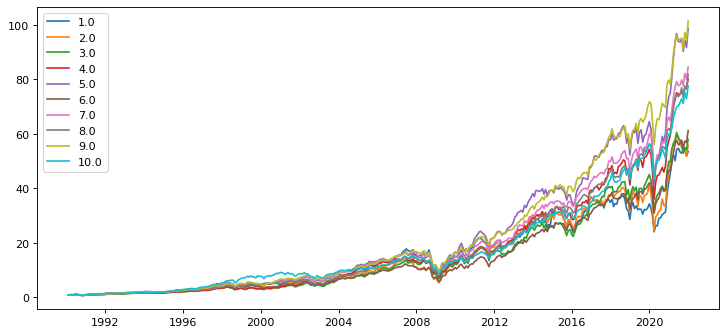

In [412]:
#equally weighted portfolio 
groups = levels[1:]*10
portfolios = pd.DataFrame(columns=groups, index =data.date[0:384])
ew_portfolios = portfolios
for i in range(1, 11):
    ew_portfolios.iloc[:,i-1] = data.groupby(["group","date"]).ret.sum()[i] * (1/33)

plt.plot((ew_portfolios + 1).cumprod(), label = groups)
plt.legend()
plt.show()


In [413]:

import statsmodels.api as sm

monthly = rf.tmytm/12
risk_free = np.exp(monthly.values/100)-1

excess_portfolios = ew_portfolios.sub(risk_free, axis=0)
market = vw_market.sub(risk_free, axis = 0)
excess_portfolios = excess_portfolios.assign(market = market.vwretd)

cov_mark_ret = excess_portfolios.cov()["market"]
var_mark = excess_portfolios.market.var()
beta = (cov_mark_ret / var_mark).iloc[0:10]

avg_mark = excess_portfolios.market.mean()
avg_group = excess_portfolios.mean().iloc[0:10]

alpha = avg_group - beta*avg_mark

for i in range(0, 10):
    market = excess_portfolios.market.to_numpy()
    y = excess_portfolios.iloc[:,i].to_numpy()
    X = sm.add_constant(market)     #add constant to predictor variables
    #fit linear regression model
    model = sm.OLS(y, X).fit()   #if we need pvalues or tvalues just go inside here 
    
print(f"Alpha \n{alpha}")
print(f'\nBeta \n{beta}')


Alpha 
1.0     0.003009
2.0     0.002086
3.0     0.002665
4.0     0.003975
5.0     0.003973
6.0     0.002969
7.0     0.004578
8.0     0.004198
9.0     0.005121
10.0    0.004087
dtype: float64

Beta 
1.0     0.973050
2.0     1.167176
3.0     1.026911
4.0     0.940974
5.0     1.034367
6.0     0.973263
7.0     0.821068
8.0     0.861697
9.0     0.809871
10.0    0.856130
Name: market, dtype: float64


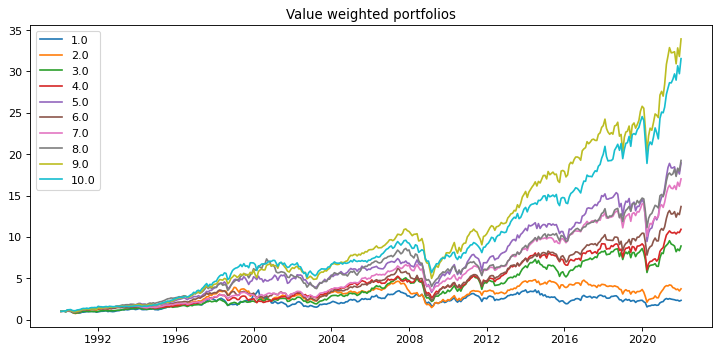

In [543]:
#value weighted portfolios 
#slow function but it works, you can see it progressing by using print(i)
#this is made by me 
#below you find the ones that is given in the solution

tot_mcap = data.groupby(["group","date"]).sum()["mcap"]
vw_portfolios = portfolios
vw_portfolios.loc[data.date[0],:] = 0

for i in range(0,10):
   # print(i)
    w = data.groupby(["group","date"]).mcap.rolling(1).sum()[i+1] / tot_mcap[i+1]   #for each group we get the weight for each period
    for j in range(0,383):   #for each date 
        index = w[data.date[j]].index    #index of these groups corresponds to the columns index of data 
        permnos = data.loc[data.index.isin(index)].permno     #we get the permno corresponding to these index 
        df = data.loc[data.date==data.date[j+1]].loc[data.permno.isin(permnos)]    #now we select the observations of the date that we need only for these permno
        df = df.set_axis(df.permno)   #set the permno as index 
        weights_to_use = w[data.date[j]].set_axis(permnos.tolist())    #selecting the weight to use for these observation 
        vw_ret = (df.ret * weights_to_use).sum()
        vw_portfolios.loc[data.date[j+1],i+1] = vw_ret
        
        
vw_portfolios.drop(data.index[data['date'] == data.date[0]], inplace=True)
plt.plot((vw_portfolios+1).cumprod(),label = groups)
plt.title("Value weighted portfolios")
plt.legend()
plt.show()


In [601]:
# function to calculate value weighted return
#this is taken by the solution we need to change names a little bit the structure if we want to use it 
#but it is much faster 

data["mcap_lag"] = data.mcap.shift(1)

def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    return (d * w).sum() / w.sum()
   

data_to_use = data.drop(data.index[data['date'] == data.date[0]], inplace=False)
vw_portfolios_2 = data_to_use.groupby(['group','date']).apply(wavg, 'ret','mcap_lag').to_frame().reset_index()


#check if the avererage per group are the same 
print(vw_portfolios_2.groupby("group").mean())
print(vw_portfolios)



,0
group,
1.0,0.004338
2.0,0.005205
3.0,0.007216
4.0,0.007498
5.0,0.009061
6.0,0.008156
7.0,0.008244
8.0,0.008741
9.0,0.010205
